## まじない

In [1]:
# %load formant
import pandas as pd
import scipy.io.wavfile
import scipy.signal
import pylab as P
import os
import wave
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from levinson_durbin import autocorr, LevinsonDurbin
import audioop
from memory_profiler import profile
import struct


# 音源をまとめてnumpy配列にする
def wav_to_numpy_dat(path, n=1024):
    '''
    read .wav file and return ndarray
    <return>
    data >> shape: (2ch, sample num), dtype: 16
    '''
    print(os.path.basename(path))
    with wave.open(path, mode='rb') as wf:
        fs = wf.getframerate()
        
        buf = wf.readframes(-1)
        data = np.frombuffer(buf, dtype='int16') / 32768.0  # (-1, 1)に正規化
        data = data.reshape((-1, 2)).T
        left = data[0]
        right = data[1]
        wav = (left+right)/2
        signal=[]
        for i in range(1,(len(wav)//n)+1):
            signal.append(wav[((i-1)*n):(i*n)])
        signal = np.array(signal)
        return signal,(len(wav)//n),float(fs)
    

def wav_to_numpy_all(path):
    print(os.path.basename(path))
    with wave.open(path, mode='rb') as wf:
        fs = wf.getframerate()
        
        buf = wf.readframes(-1)
        data = np.frombuffer(buf, dtype='int16') / 32768.0  # (-1, 1)に正規化
        data = data.reshape((-1, 2)).T
        left = data[0]
        right = data[1]
        wav = (left+right)/2
        
        return wav, 1, float(fs)


def preEmphasis(signal, p):
    """プリエンファシスフィルタ"""
    # 係数 (1.0, -p) のFIRフィルタを作成
    return scipy.signal.lfilter([1.0, -p], 1, signal)


def plot_signal(s, a, e, fs, lpcOrder, file):   
    t = np.arange(0.0, len(s) / fs, 1/fs)
    # LPCで前向き予測した信号を求める
    predicted = np.copy(s)
    # 過去lpcOrder分から予測するので開始インデックスはlpcOrderから
    # それより前は予測せずにオリジナルの信号をコピーしている
    for i in range(lpcOrder, len(predicted)):
        predicted[i] = 0.0
        for j in range(1, lpcOrder):
            predicted[i] -= a[j] * s[i - j]
    # オリジナルの信号をプロット
    P.plot(t, s)
    # LPCで前向き予測した信号をプロット
    P.plot(t, predicted, "r", alpha=0.4)
    P.xlabel("Time (s)")
    P.xlim((-0.001, t[-1]+0.001))
    P.title(file)
    P.grid()
    P.show()
    return 0


def plot_spectrum(s, a, e, fs, file):
    # LPC係数の振幅スペクトルを求める
    nfft = 2048   # FFTのサンプル数
    fscale = np.fft.fftfreq(nfft, d=1.0 / fs)[:int(nfft/2)] #dがサンプリング周期　return サンプリング周波数
    
    # オリジナル信号の対数スペクトル
    spec = np.abs(np.fft.fft(s, nfft))
    logspec= 20 * np.log10(spec)
#     print("logspec.shape:", logspec[:int(nfft/2)].shape)
#     P.plot(fscale, logspec[:int(nfft/2)])
#     P.show()
    
    # LPC対数スペクトル  1/A(z)の周波数応答をプロット
    w, h = scipy.signal.freqz(np.sqrt(e), a, nfft, "whole")
    lpcspec = np.abs(h)
    loglpcspec = 20 * np.log10(lpcspec)
#     print("loglpcspec.shape:", loglpcspec[:int(nfft/2)].shape)
    fscale =  (fs * w / 2.0 / np.pi)[:int(nfft/2)]
#     P.plot(fscale, loglpcspec[:int(nfft/2)], "r", linewidth=2)
#     image = P.plot(fscale, loglpcspec[:int(nfft/2)], "r", linewidth=2)
#     P.xlabel("Frequency (Hz)")
#     P.xlim((-100,nfft/2))
#     P.title(file)
#     P.grid()
#     P.show()
    return fscale,loglpcspec[:int(nfft/2)]


# LPCスペクトル包絡
def lpc_spectral_envelope(file, n=1024):
    """
    Parameters
    ------------
    n : サンプル長
    """    
    # 音声をロード
    data, num, fs = wav_to_numpy_dat(file, n) # 1024サンプルごとのリストを返却
#     data, num, fs = wav_to_numpy(file) # ファイルまるごとnumpy配列
    print("num: ", num)
    print("data.shape:", data.shape)
    result = []
    for i in range(num):
        wav = data[i]
        aa = wav.shape[0]
        t = np.arange(0.0, float(aa)/fs, 1/fs)
        # 音声波形の中心部分を切り出す
        center = len(wav) / 2  # 中心のサンプル番号
        cuttime = 0.3         # 切り出す長さ [s]
        s = wav[int(center - cuttime/2*fs): int(center + cuttime/2*fs)] # 中心から0.04秒切り出す⇒N=1764
#         print("s.shape:", s.shape)
        # プリエンファシスフィルタをかける
        p = 0.97         # プリエンファシス係数
        s = preEmphasis(s, p)
        # ハミング窓をかける fftする前に窓関数かけなあかんのね
        hammingWindow = np.hamming(len(s))
        s = s * hammingWindow
        # LPC係数を求める
        lpcOrder = 32
        r = autocorr(s, lpcOrder + 1)
        a, e = LevinsonDurbin(r, lpcOrder)
    #     plot_signal(s, a, e, fs, lpcOrder, file)

        fscale, data_result = plot_spectrum(s, a, e, fs, file)
#         print("data_result.shape:", data_result.shape)
        result.append(data_result)
    result = np.array(result)
    return result

/Users/sotobenjamin/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/sotobenjamin/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from mpl_toolkits.mplot3d import Axes3D

def display_(features, datanum=None):
    plt_features = len(features)

    if plt_features == 3:
        f1, f2, f3 = features
        fig = plt.figure(figsize=(8, 6))
        ax = Axes3D(fig, title='Result')

        ax.set_xlabel("1st feature")
        ax.set_ylabel("2nd feature")
        ax.set_zlabel("3rd feature")

        if type(datanum) == list:
            idx = 0
            for num in datanum:
                ax.scatter(f1[idx:idx+num],
                           f2[idx:idx+num],
                           f3[idx:idx+num])
                idx += num
        elif type(datanum) == int:
            for i in range(len(features)//datanum):
                ax.scatter(f1[datanum*i:datanum*(i+1)],
                           f2[datanum*i:datanum*(i+1)],
                           f3[datanum*i:datanum*(i+1)])
        else:
            ax.scatter(f1, f2, f3)

        plt.show()

    elif plt_features == 2:
#         c=['#984ea3','#a65628',]
        f1, f2 = features
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot('111',
                             title='Result',
                             xlabel='1st feature',
                             ylabel='2nd feature')

        if type(datanum) == list:
            idx = 0
            for i, num in enumerate(datanum):
                ax.scatter(f1[idx:idx+num],
                           f2[idx:idx+num],alpha=0.5)#,c=c[i])
                idx += num
        elif type(datanum) == int:
            for i in range(len(features)//datanum):
                ax.scatter(f1[datanum*i:datanum*(i+1)],
                           f2[datanum*i:datanum*(i+1)])
        else:
            ax.scatter(f1, f2)
        
        plt.show()

    elif plt_features == 1:
#         c=['#984ea3','#a65628',]
        f1 = features[0]
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot('111',
                             title='Result',
                             xlabel='input data',
                             ylabel='1st feature')

        if type(datanum) == list:
            idx = 0
            for i, num in enumerate(datanum):
                ax.plot(f1[idx:idx+num])#,c=c[i])
                idx += num
        elif type(datanum) == int:
            for i in range(len(features)//datanum):
                ax.plot(f1[datanum*i:datanum*(i+1)])
        else:
            ax.plot(f1)
        
        plt.show()

In [3]:
import wave as wave
import numpy as np
import matplotlib.pyplot as plt

def show_spectrum(wav_path,fig_size=(10,4)):

    #ファイルを読み込む
    wav=wave.open(wav_path)

    #PCM形式の波形データを読み込み
    data=wav.readframes(wav.getnframes())

    #dataを2バイトの数値列に変換
    data=np.frombuffer(data, dtype=np.int16)

    #waveファイルを閉じる
    wav.close()

    #スペクトログラムをプロットする
    fig=plt.figure(figsize=fig_size)
    
    #スペクトログラムを表示する
    spectrum,  freqs, t, im=plt.specgram(data,NFFT=512,noverlap=512/16*15,Fs=wav.getframerate())
    
    #データ形確認
    print("t.shape : ",t.shape)
    print("freqs.shape : ",freqs.shape)

    #カラーバーを表示する
    fig.colorbar(im).set_label('Intensity [dB]')

    #x軸のラベル
    plt.xlabel("Time [sec]")

    #y軸のラベル
    plt.ylabel("Frequency [Hz]")

    #画像を画面に表示
    plt.show()

def wav_to_stft(wav_path,check=False):

    import wave as wave
    import numpy as np
    import scipy.signal as sp


    #ファイルを読み込む
    wav=wave.open(wav_path)
    #PCM形式の波形データを読み込み
    data=wav.readframes(wav.getnframes())
    #dataを2バイトの数値列に変換
    data=np.frombuffer(data, dtype=np.int16)
    #waveファイルを閉じる
    wav.close()

    #短時間フーリエ変換を行う
    f,t,stft_data=sp.stft(data,fs=wav.getframerate(),window="hann",nperseg=512,noverlap=256)
    
    if check:
        print("sampling frequency",wav.getframerate())
        #短時間フーリエ変換後のデータ形式を確認
        print("短時間フーリエ変換後のshape: ",np.shape(stft_data))
        # stft_dataの中身
        print("stft_data: ",stft_data)


        #周波数軸の情報
        print("周波数 list length: ",len(f))
        print("周波数軸 [Hz]: ",f)

        #時間軸の情報
        print("時間 list length: ",len(t))
        print("時間軸[sec]: ",t)
        
    return f,t,stft_data

## trainデータ作成

In [4]:
r_path = "./vocals/umberella/r_short3.wav"
t_path = "./vocals/umberella/t_short3.wav"

t.shape :  (5497,)
freqs.shape :  (257,)


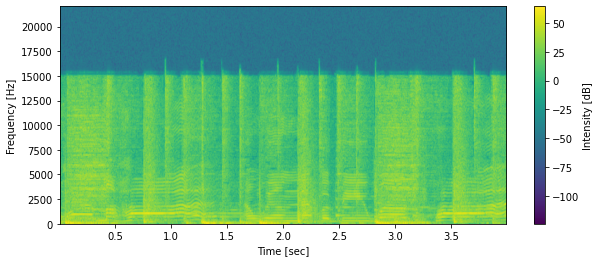

In [5]:
show_spectrum(r_path)

t.shape :  (5497,)
freqs.shape :  (257,)


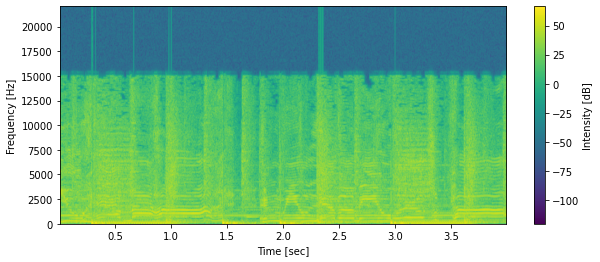

In [6]:
show_spectrum(t_path)

In [7]:
# stft  data　の複素数を絶対値をとって
def to_abs(data):
    try:
        abs_data = np.array([])
        for f in data:
            abs_list = []
            for i in f:
                abs_list.append(20*np.log10(abs(i)))
            abs_data = np.append(abs_data,np.array(abs_list))
        return abs_data.reshape(data.shape)
    except :
        print('Error: data must be 2 dimension array')

r_short3.wav
num:  86
data.shape: (86, 1024)
t_short3.wav
num:  86
data.shape: (86, 1024)
r_data1.shape (86, 1024)
t_data1.shape (86, 1024)


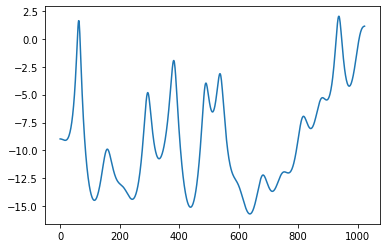

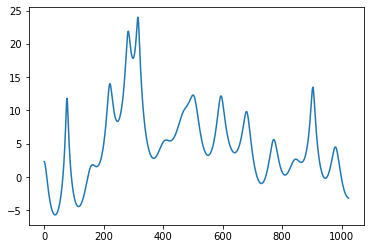

In [9]:
r_data1 = lpc_spectral_envelope(r_path)
t_data1 = lpc_spectral_envelope(t_path)


print("r_data1.shape",r_data1.shape)
print("t_data1.shape",t_data1.shape)

# r_df_stft = pd.DataFrame(r_data1)
# t_df_stft = pd.DataFrame(t_data1)

plt.plot(r_data1[0])
plt.show()

plt.plot(t_data1[0])
plt.show()

In [10]:
train = np.concatenate([r_data1,t_data1], axis=0)
train.shape

(172, 1024)

### 参照系作成

In [11]:
r_ref_path = "./vocals/umberella/r_ref3.wav"
t_ref_path = "./vocals/umberella/t_ref3.wav"

t.shape :  (5497,)
freqs.shape :  (257,)


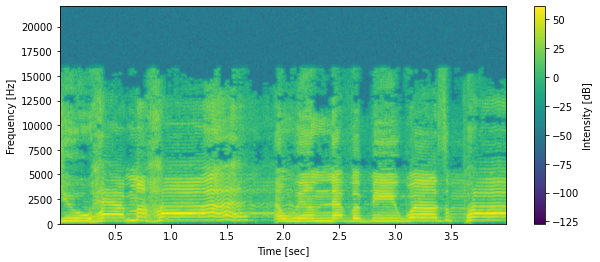

In [12]:
show_spectrum(r_ref_path)

t.shape :  (2741,)
freqs.shape :  (257,)


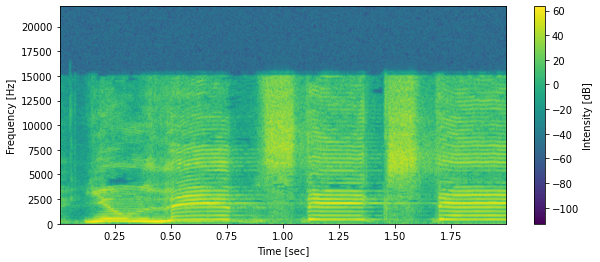

In [13]:
show_spectrum(t_ref_path)

r_ref3.wav
num:  86
data.shape: (86, 1024)
t_ref3.wav
num:  43
data.shape: (43, 1024)
r_ref_data1.shape (86, 1024)
t_ref_data1.shape (43, 1024)


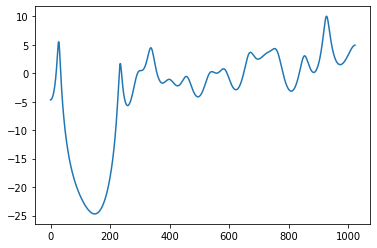

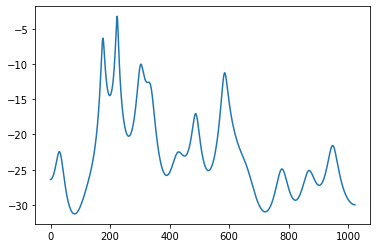

In [21]:
r_ref_data1 = lpc_spectral_envelope(r_ref_path)
t_ref_data1 = lpc_spectral_envelope(t_ref_path)


print("r_ref_data1.shape",r_ref_data1.shape)
print("t_ref_data1.shape",t_ref_data1.shape)

# r_df_stft = pd.DataFrame(r_data1)
# t_df_stft = pd.DataFrame(t_data1)

plt.plot(r_ref_data1[0])
plt.show()

plt.plot(t_ref_data1[0])
plt.show()

In [22]:
r_ref = r_ref_data1[0]
t_ref = t_ref_data1[0]
print("r_ref.shape:",r_ref.shape)
print("t_ref.shape:",t_ref.shape)

r_ref.shape: (1024,)
t_ref.shape: (1024,)


### AIRで学習

In [23]:
%%time
from aireference import AIR


air = AIR()

r_result = air(train, r_ref)
# t_result = air(train, t_ref)

CPU times: user 4.74 s, sys: 254 ms, total: 4.99 s
Wall time: 4.24 s


### testデータ作成

In [69]:
r_test_path = "./vocals/umberella/r_test3.wav"
t_test_path = "./vocals/umberella/t_test3.wav"

t.shape :  (2741,)
freqs.shape :  (257,)


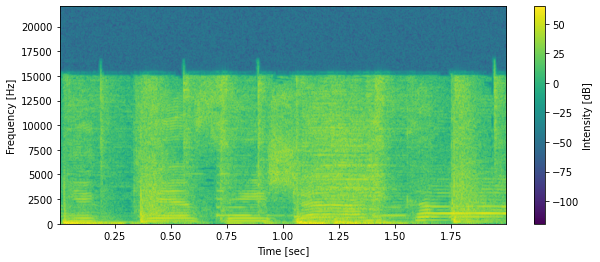

In [70]:
show_spectrum(r_test_path)

t.shape :  (2741,)
freqs.shape :  (257,)


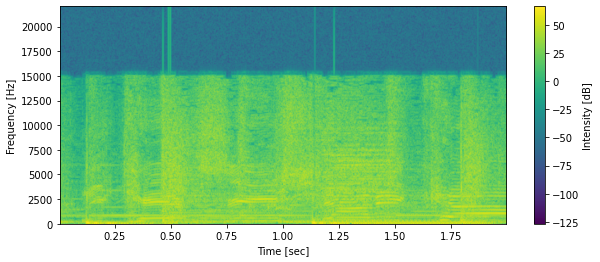

In [71]:
show_spectrum(t_test_path)

r_test3.wav
num:  43
data.shape: (43, 1024)
t_test3.wav
num:  43
data.shape: (43, 1024)
r_test_data1.shape (43, 1024)
t_test_data1.shape (43, 1024)


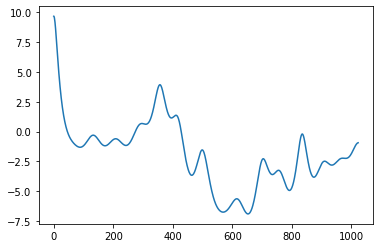

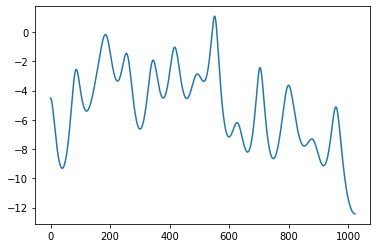

In [72]:
r_test_data1 = lpc_spectral_envelope(r_test_path)
t_test_data1 = lpc_spectral_envelope(t_test_path)


print("r_test_data1.shape",r_test_data1.shape)
print("t_test_data1.shape",t_test_data1.shape)

datanum=[r_test_data1.shape[0],t_test_data1.shape[0]]

# r_df_stft = pd.DataFrame(r_data1)
# t_df_stft = pd.DataFrame(t_data1)

plt.plot(r_test_data1[0])
plt.show()

plt.plot(t_test_data1[0])
plt.show()

In [73]:
test = np.concatenate([r_test_data1,t_test_data1], axis=0)
test.shape

(86, 1024)

## 分離できてるけどLPCスペクトル包絡が負だからラベルがひっくり返ってる
### ~そこは人間が後で判断すればいいのかな．というかAIRで分離されたデータに判断を下すのは人間やん~

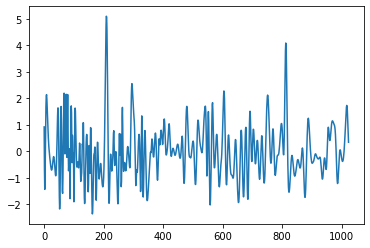

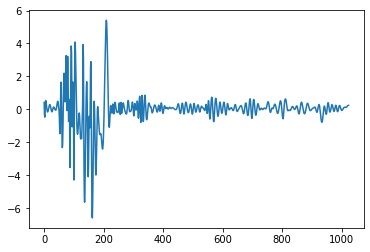

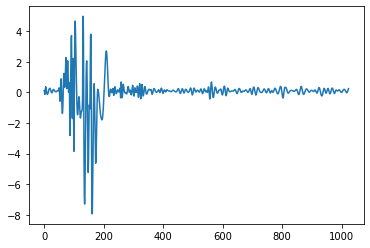

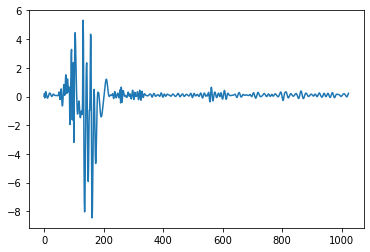

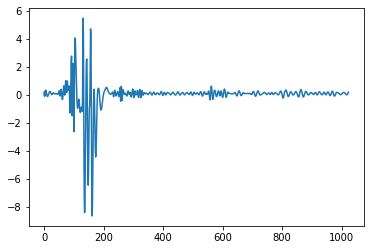

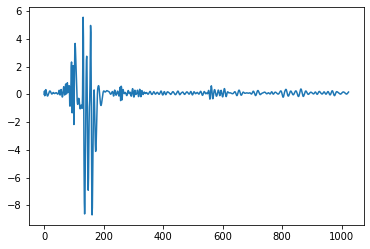

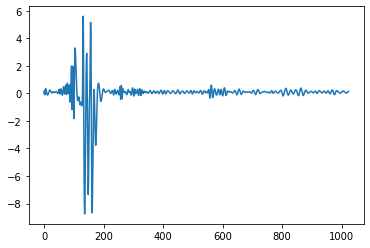

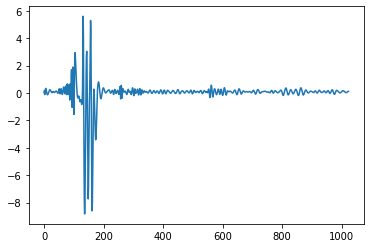

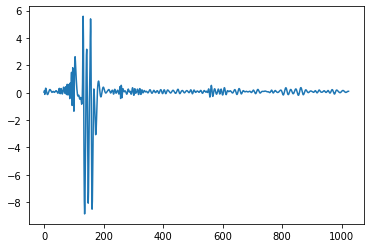

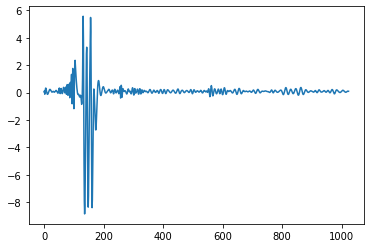

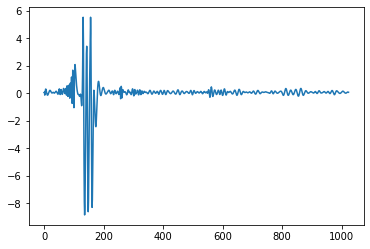

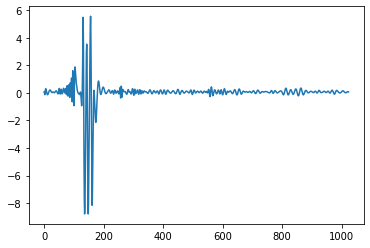

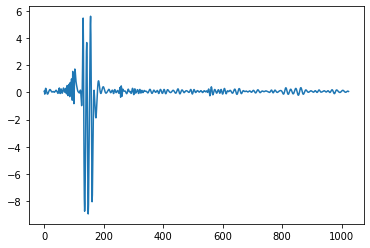

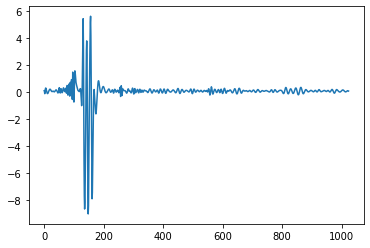

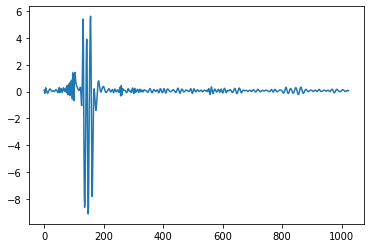

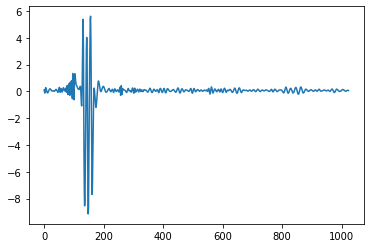

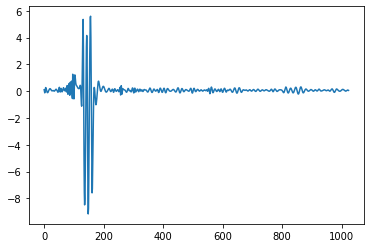

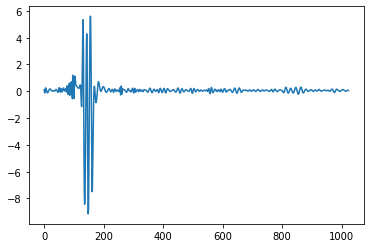

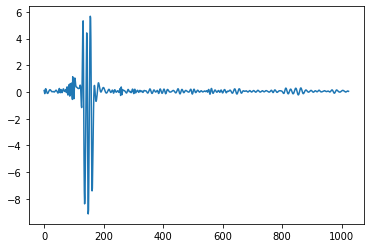

In [74]:
# 特徴量確認
for i in range(1,20):
    r_result.epoch(i)[1].show()

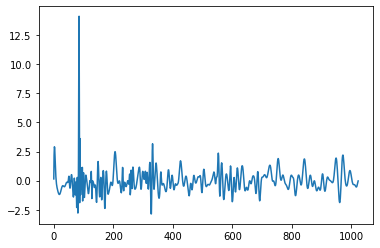

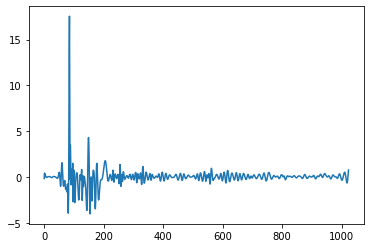

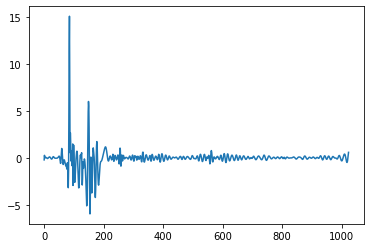

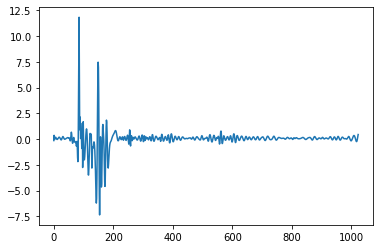

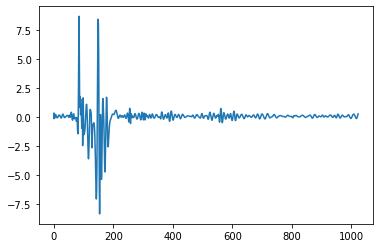

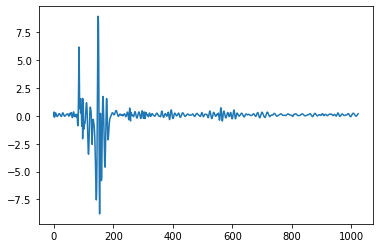

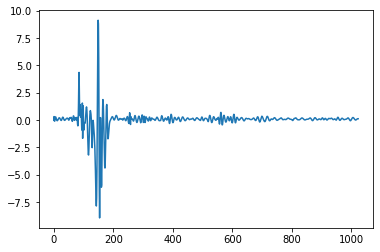

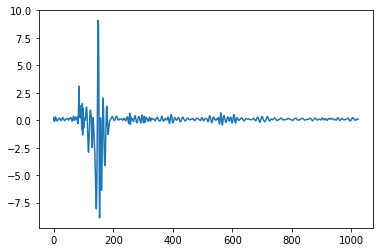

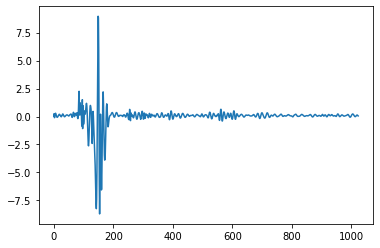

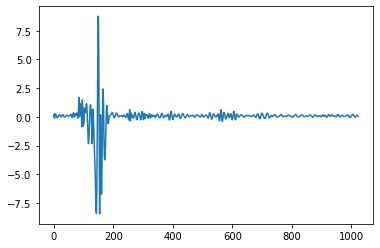

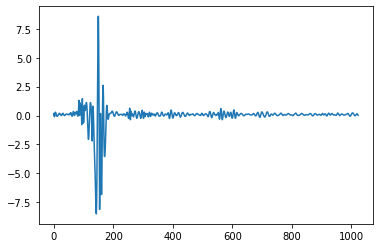

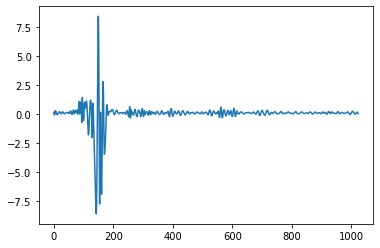

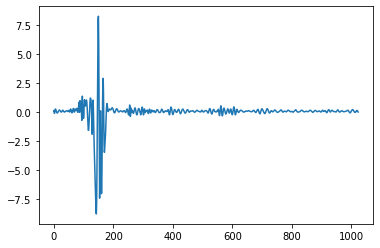

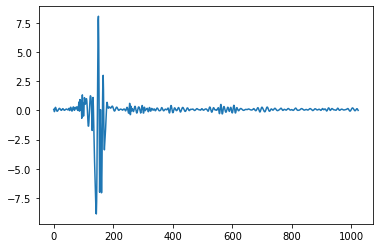

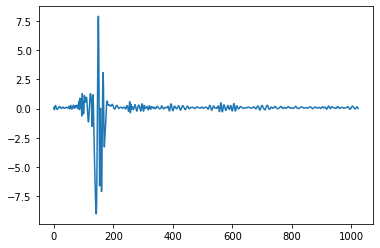

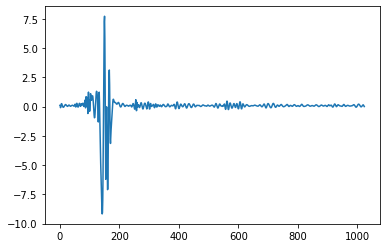

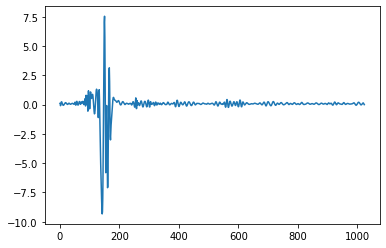

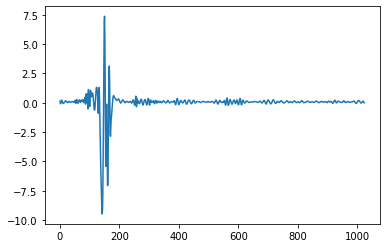

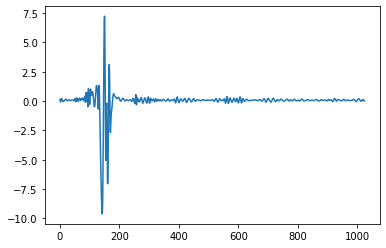

In [75]:
# 特徴量確認
for i in range(1,20):
    r_result.epoch(i)[2].show()

In [79]:
datanum=[r_test_data1.shape[0],t_test_data1.shape[0]]
datanum

[43, 43]

In [80]:
def result_plot(features,datanum):
    f1,f2 = features
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot('111',
                         title='Result',
                         xlabel='1st feature',
                         ylabel='2nd feature')

    if type(datanum) == list:
        idx = 0
        for i, num in enumerate(datanum):
            ax.scatter(f1[idx:idx+num],
                       f2[idx:idx+num],alpha=0.5)#,c=c[i])
            idx += num
    elif type(datanum) == int:
        for i in range(len(features)//datanum):
            ax.scatter(f1[datanum*i:datanum*(i+1)],
                       f2[datanum*i:datanum*(i+1)])
    else:
        ax.scatter(f1, f2)

    plt.show()

epocs : 1


/Users/sotobenjamin/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


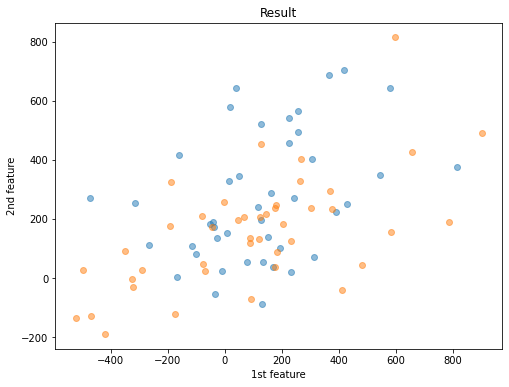

epocs : 2


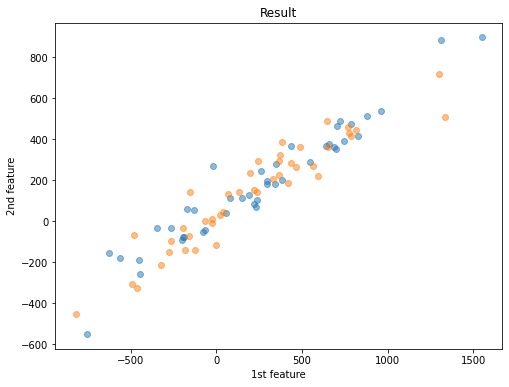

epocs : 3


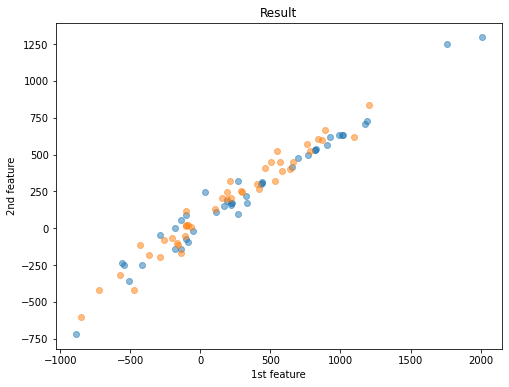

epocs : 4


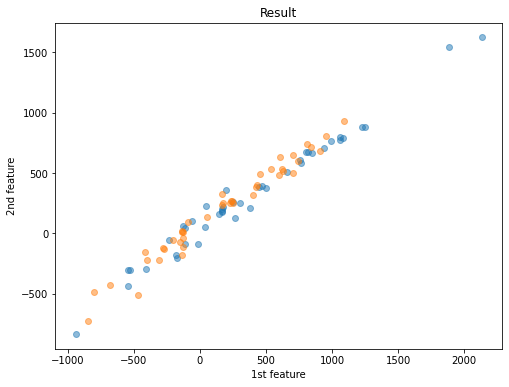

epocs : 5


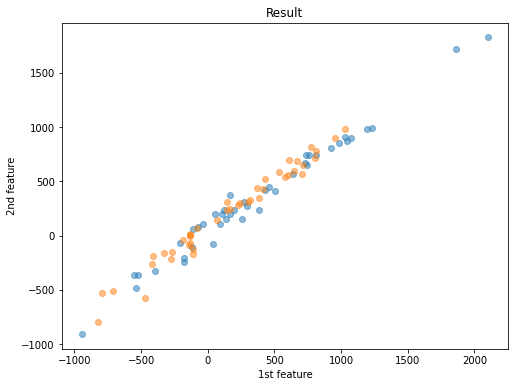

epocs : 6


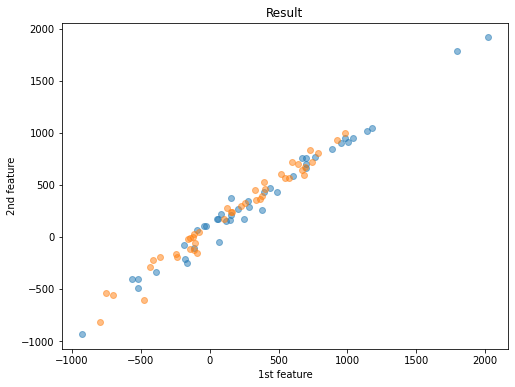

epocs : 7


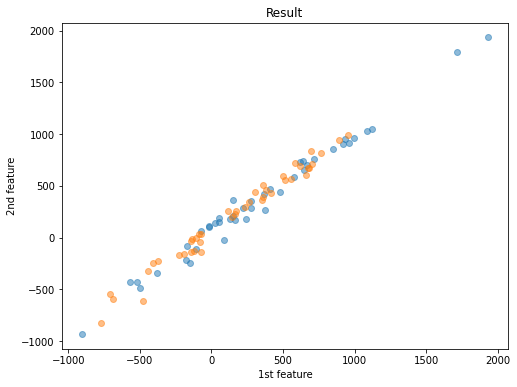

epocs : 8


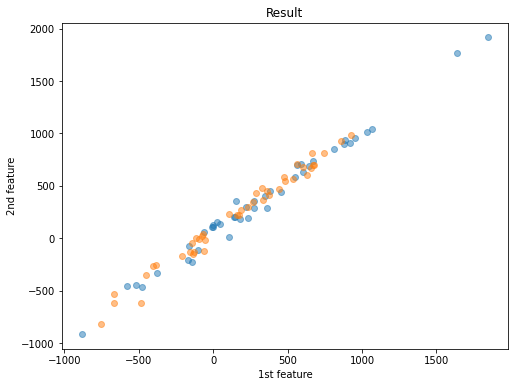

epocs : 9


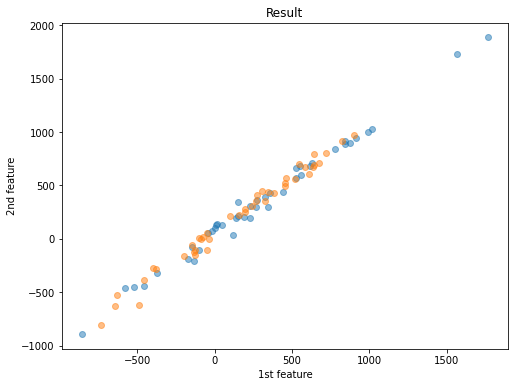

epocs : 10


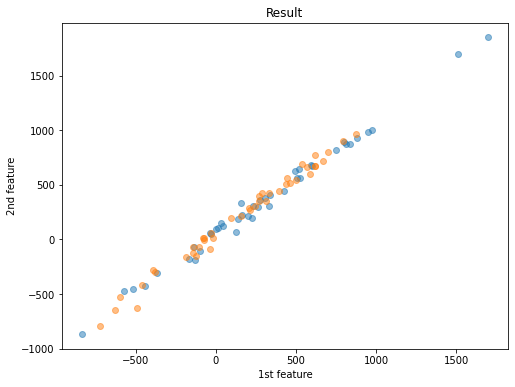

epocs : 11


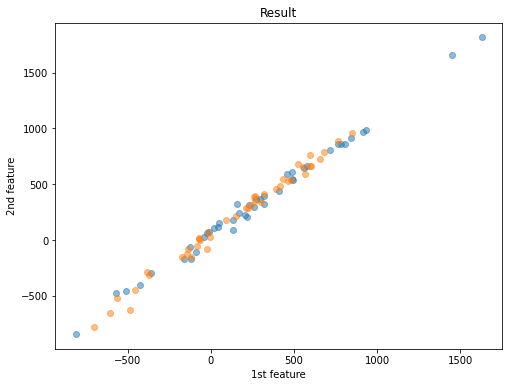

epocs : 12


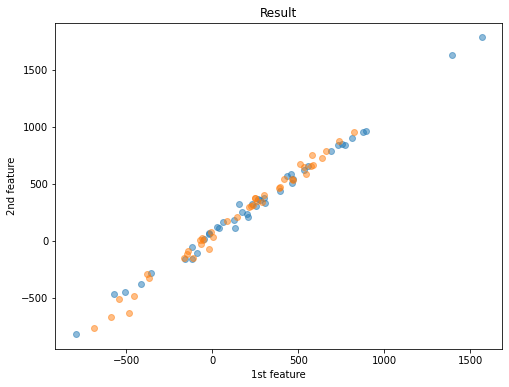

epocs : 13


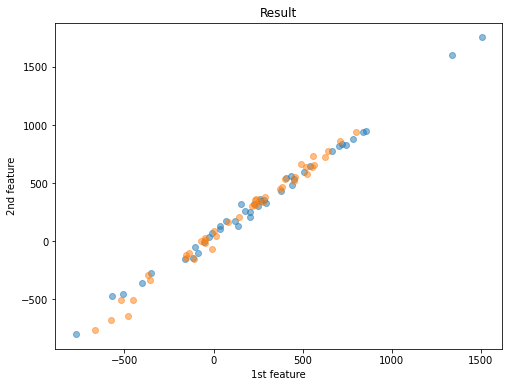

epocs : 14


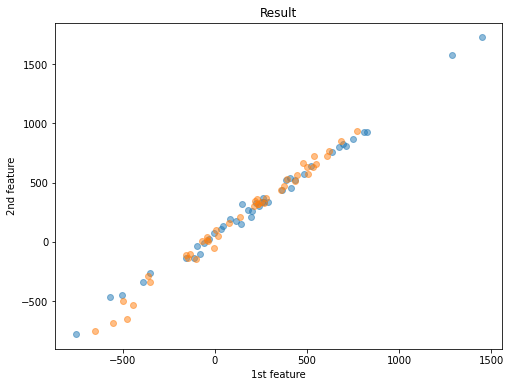

epocs : 15


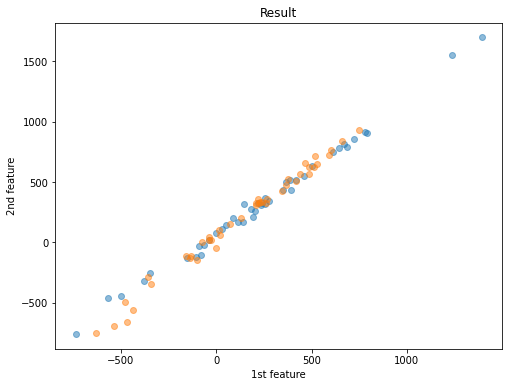

epocs : 16


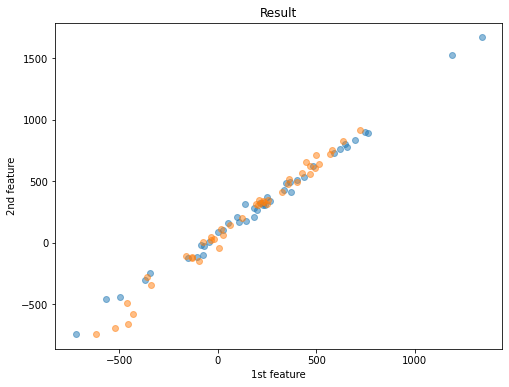

epocs : 17


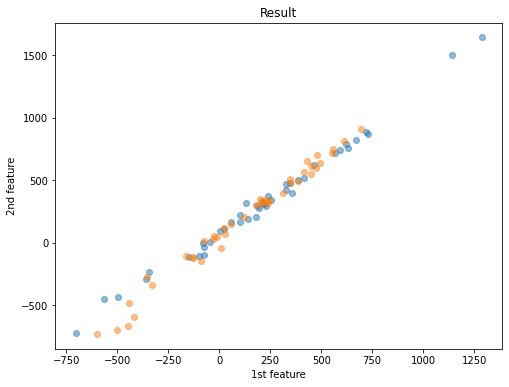

epocs : 18


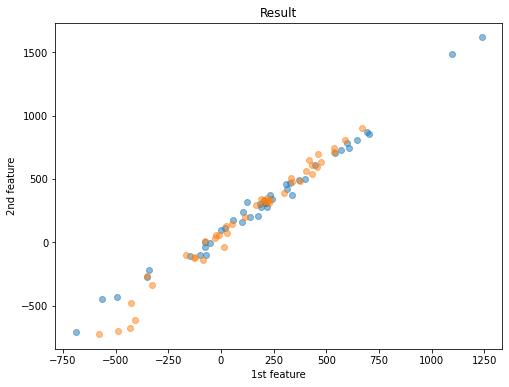

epocs : 19


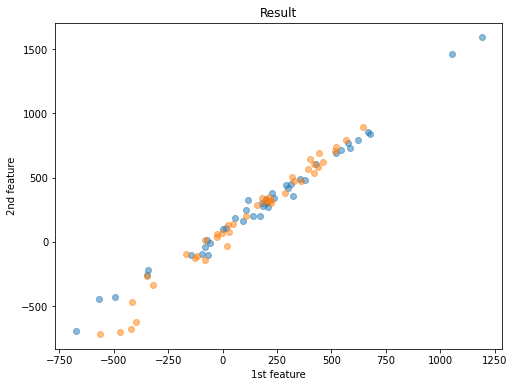

In [84]:
for i in range(1,20):
    feature_1 = r_result.epoch(i)[1](test)
    feature_2 = r_result.epoch(i)[2](test)
    features = [feature_1, feature_2]
    # print("feature_1.shape:",feature_1.shape)
    # print("feature_2.shape:",feature_2.shape)
    print("epocs :",i)
    result_plot(features, datanum)

In [58]:
feature_1 = r_result.epoch(1)[1](test)
feature_2 = r_result.epoch(1)[2](test)
print("feature_1.shape:",feature_1.shape)
print("feature_2.shape:",feature_2.shape)

features = [feature_1, feature_2]
# display([feature_1, feature_2], datanum=[346, 346])

feature_1.shape: (86,)
feature_2.shape: (86,)


/Users/sotobenjamin/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


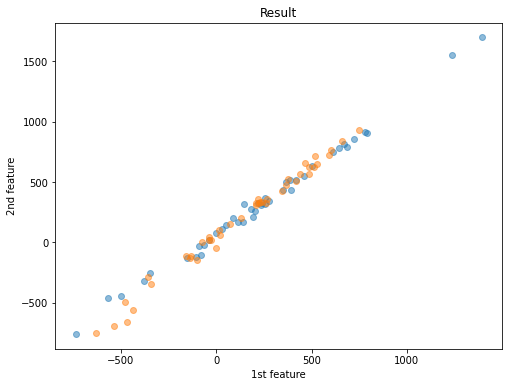

In [60]:
f1,f2 = features
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot('111',
                     title='Result',
                     xlabel='1st feature',
                     ylabel='2nd feature')

if type(datanum) == list:
    idx = 0
    for i, num in enumerate(datanum):
        ax.scatter(f1[idx:idx+num],
                   f2[idx:idx+num],alpha=0.5)#,c=c[i])
        idx += num
elif type(datanum) == int:
    for i in range(len(features)//datanum):
        ax.scatter(f1[datanum*i:datanum*(i+1)],
                   f2[datanum*i:datanum*(i+1)])
else:
    ax.scatter(f1, f2)

plt.show()

# 以下ユースケタカハッシのコード

# melスペクトラムで分類

In [290]:
import librosa
from librosa import display

def log_mel_spectrogram(audio_path):
    """
    Parameters
    ------------
    audio_path (srt) : 音声ファイルのパス
        
        
    Returns
    ------------
    leg_mel (ndarray[channel数(default=128), t])
    """    
    # Load
    data, sr = librosa.load(audio_path)
    print(type(data))
    
    # 無音区間の除去
#     if trim:
#         data = librosa.effects.trim(data, self.threshold)
    
    # 短時間フーリエ変換
    S_F = librosa.stft(data, n_fft=512,) # 音声処理ではn_fft=512が一般的らしい
#     print("S_F.shape:",S_F.shape) #-> (257, 345)

    # 振幅に変換
    amp = np.abs(S_F)

    # パワーに変換（振幅を二乗する）
    P_ = amp ** 2

    # メル周波数のスペクトログラムを求める
    mel = librosa.feature.melspectrogram(S=P_, sr=sr)
    print("mel.shape:", mel.shape) #-> (128, 345)

    log_mel = np.log10(mel) # 底は10(eのやつもあるぽい？)
    
    # 可視化
    librosa.display.specshow(log_mel, sr=sr, y_axis='mel')
    plt.xlabel("t")
    plt.xticks([0,50,100,150,200,250,300])
    plt.colorbar()
    plt.show()
    
    return log_mel

<class 'numpy.ndarray'>
mel.shape: (128, 345)


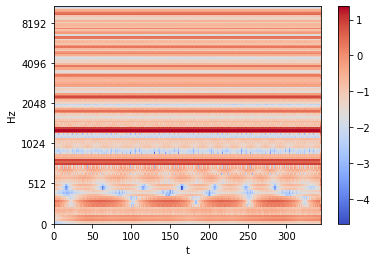

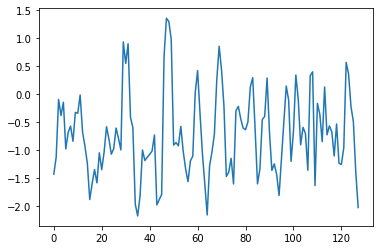

<class 'numpy.ndarray'>
mel.shape: (128, 345)


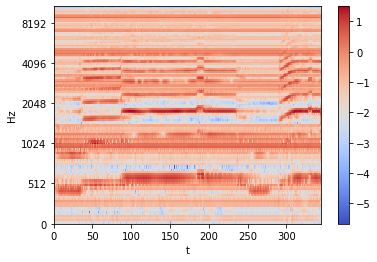

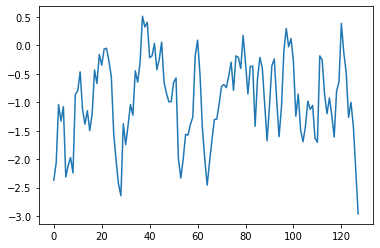

(690, 128)


In [291]:
#trianデータ作成

train = []
train_path_set = ["input/mixed/cello10000_train_10_trimed.wav", "input/mixed/saxphone1000_train_10_trimed.wav"]
for path in train_path_set:
    data = log_mel_spectrogram(path).T
    
    plt.plot(data.mean(axis=0))
    plt.show()
    
    data = data.tolist()
    train+=data
    
train = np.array(train)
print(train.shape)

<class 'numpy.ndarray'>
mel.shape: (128, 345)


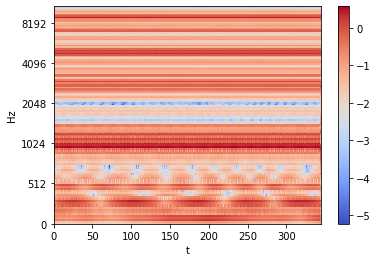

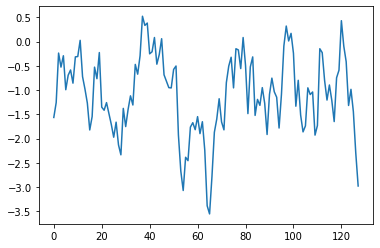

<class 'numpy.ndarray'>
mel.shape: (128, 345)


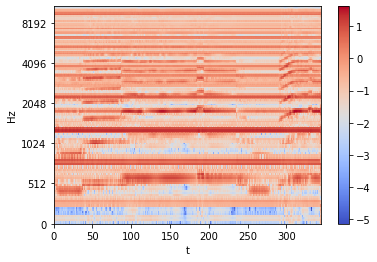

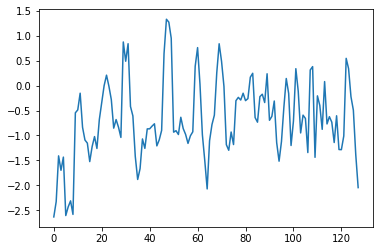

(690, 128)


In [211]:
#testデータ作成

test = []
test_path_set = ["input/mixed/cello1000_test_10_trimed.wav", "input/mixed/saxphone10000_test_10_trimed.wav"]
for path in test_path_set:
    data = log_mel_spectrogram(path).T
    
    plt.plot(data.mean(axis=0))
    plt.show()
    
    data = data.tolist()
    test+=data
    
test = np.array(test)
print(test.shape)

<class 'numpy.ndarray'>
mel.shape: (128, 345)


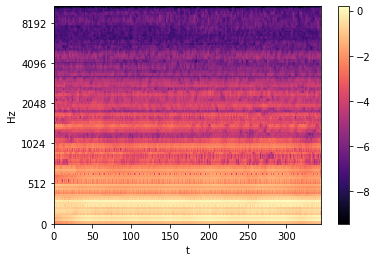

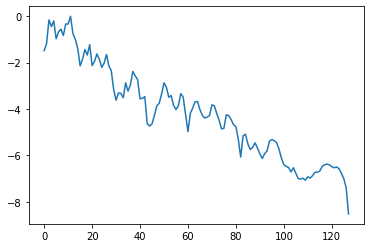

(128,)


In [292]:
# Celloの参照系作成
cello = log_mel_spectrogram("./input/dataset/Cello/003b91e8_trimd.wav").T
# print(cello[972:972+345].shape)
plt.plot(cello.mean(axis=0))
plt.show()

ref_cello = cello.mean(axis=0)
print(ref_cello.shape)

<class 'numpy.ndarray'>
mel.shape: (128, 345)


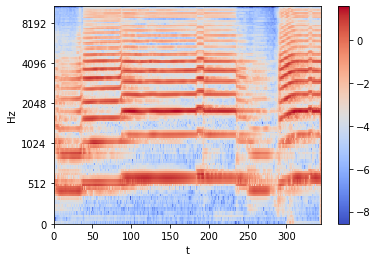

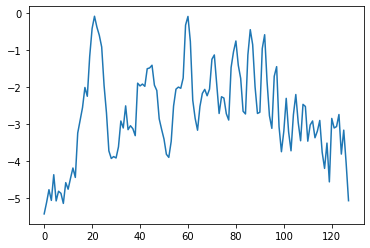

(128,)


In [293]:
# Saxphoneの参照系作成
saxphone = log_mel_spectrogram("./input/dataset/Saxophone/2bc84744_trimed.wav").T

plt.plot(saxphone.mean(axis=0))
plt.show()

ref_saxphone = saxphone.mean(axis=0)
print(ref_saxphone.shape)

In [294]:
from aireference import AIR

# @profile notebookだと実行できないので注意
def train_air():
    air = AIR()

    result_cello = air(train, ref_cello)
    result_saxphone = air(train, ref_saxphone)
    
    return result_cello, result_saxphone

In [295]:
%%time
result_cello, result_saxphone = train_air()

Wall time: 3min 20s


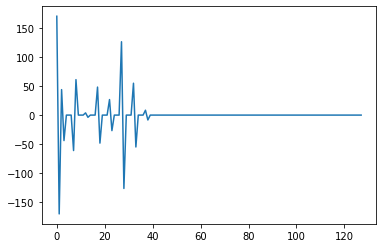

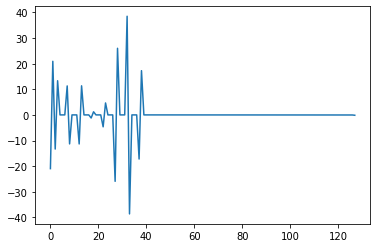

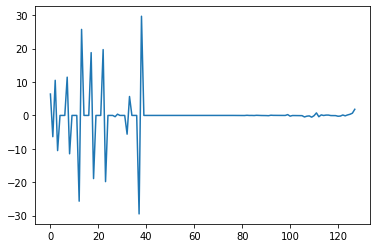

In [239]:
for i in range(3):
    result_cello.epoch(6)[i].show()

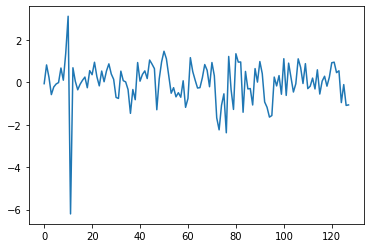

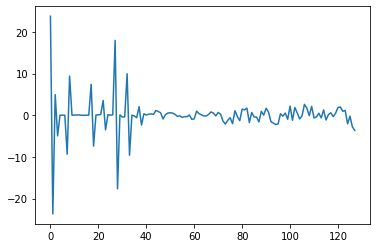

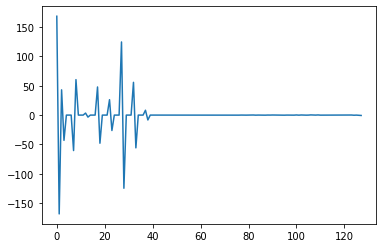

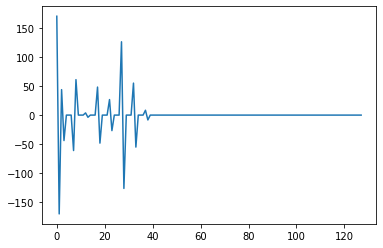

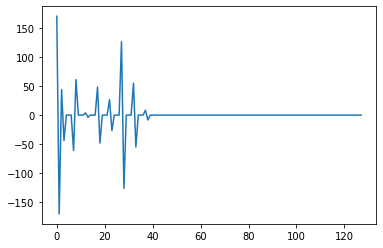

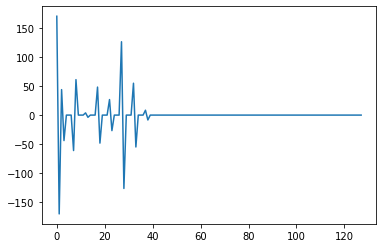

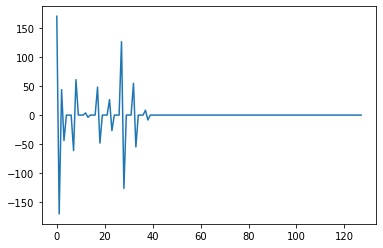

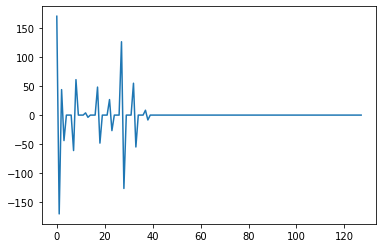

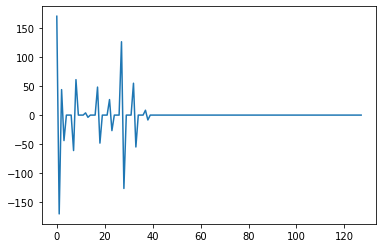

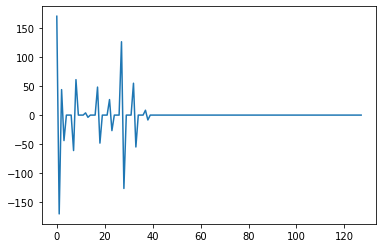

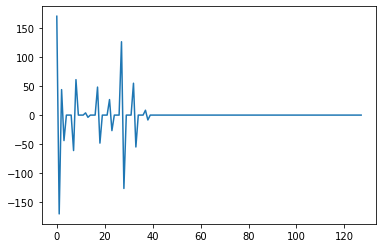

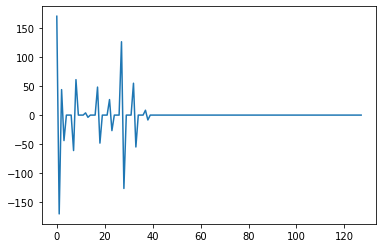

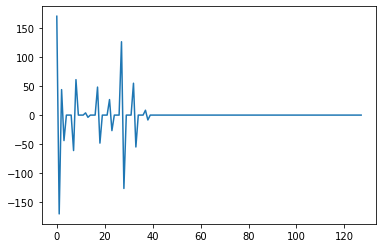

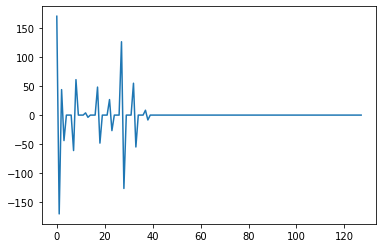

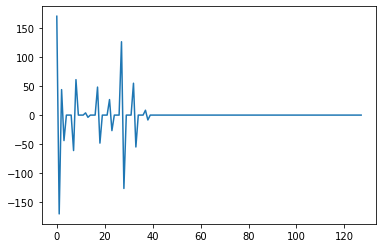

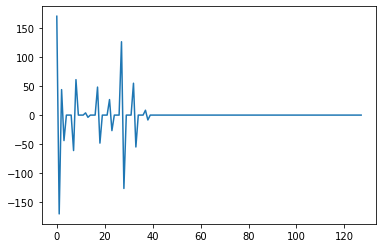

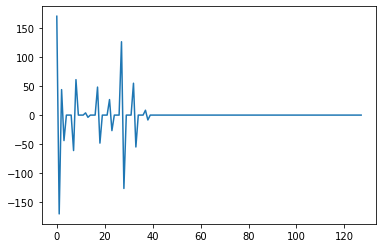

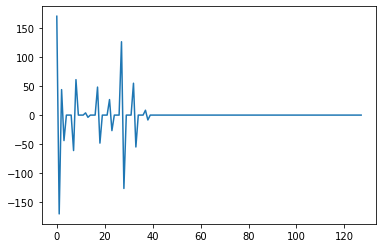

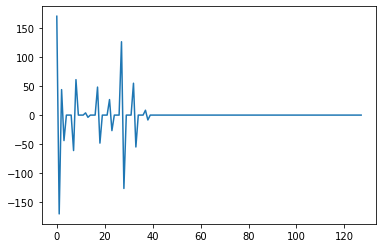

In [221]:
for i in range(1,20):
    result_cello.epoch(i)[0].show()

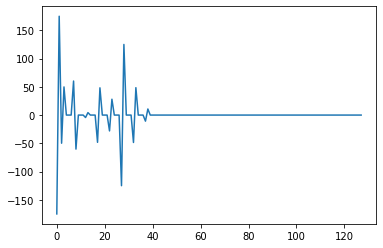

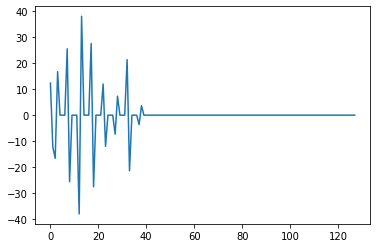

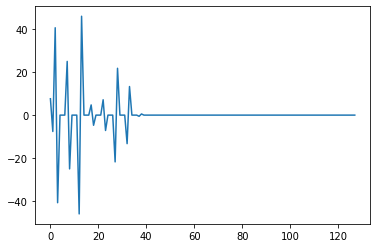

In [238]:
for i in range(3):
    result_saxphone.epoch(6)[i].show()

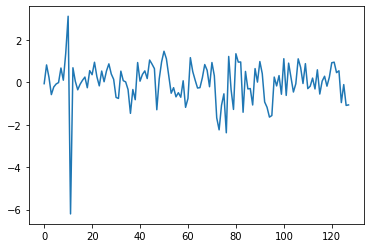

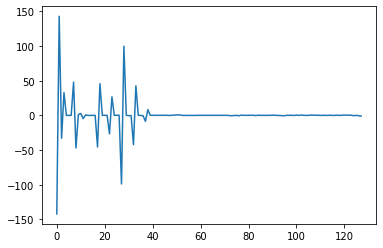

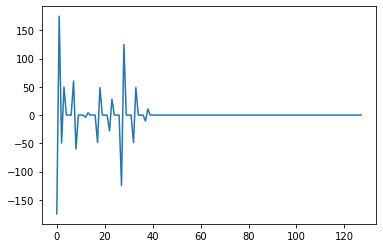

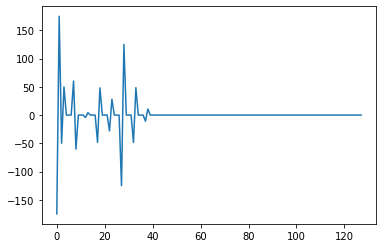

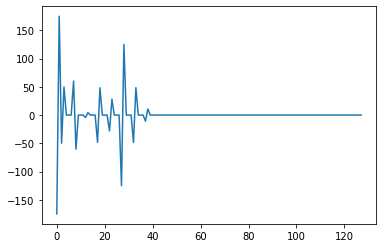

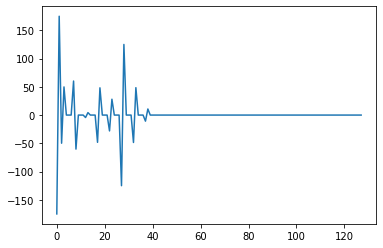

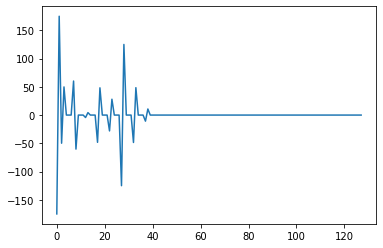

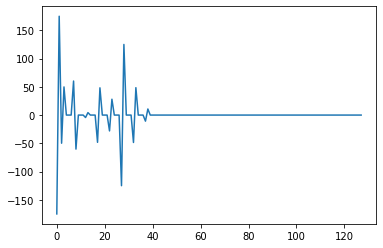

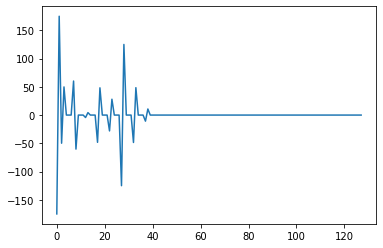

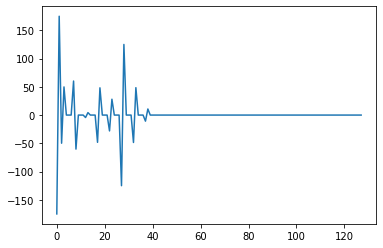

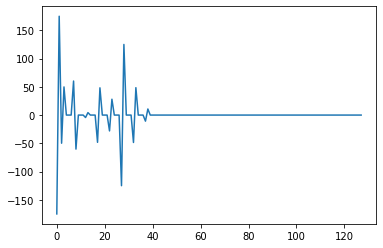

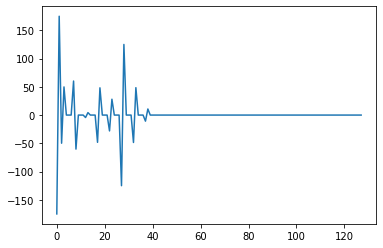

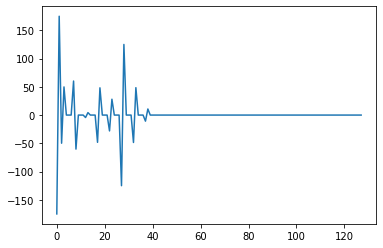

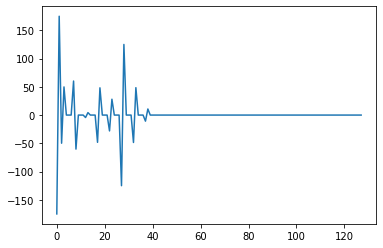

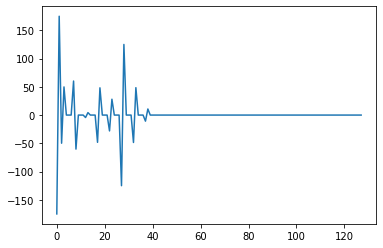

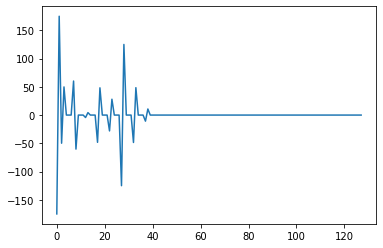

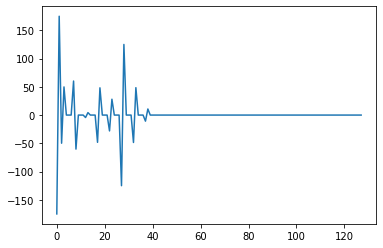

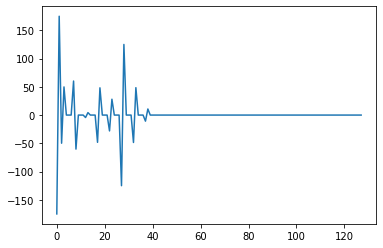

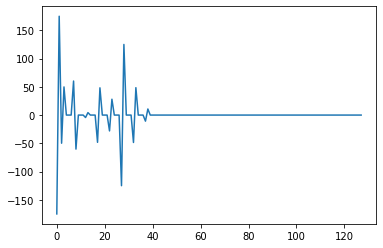

In [222]:
for i in range(1,20):
    result_saxphone.epoch(i)[0].show()

In [63]:
print(result_cello.epoch(3)[1].numpy - result_saxphone.epoch(3)[1].numpy)
print()
# print(result_cello.epoch(4)[1].numpy - result_saxphone.epoch(4)[1].numpy)

[-2.48510005e+01  2.47908147e+01 -1.80695726e+00  1.80148421e+00
  4.94604430e-02 -4.52397644e-02  4.78145828e-02 -1.85804988e+01
  1.86130623e+01  1.22670633e-02 -4.19234921e-02  3.19594423e-02
  3.24499695e+01 -3.24749384e+01  2.19325788e-02 -1.48781725e-02
  5.52427186e-02 -1.34153449e+01  1.35025289e+01  3.01767937e-02
  3.08741898e-02  3.30162514e-02 -8.75352511e+00  8.86428903e+00
  3.42450804e-02 -4.26495147e-03  5.97339917e-02 -2.46581445e+00
  2.58654009e+00  3.78437892e-02  6.05972898e-02  2.95692200e-02
 -1.38779816e+01  1.40666668e+01  3.87952026e-02  4.69874284e-02
  3.81149888e-02 -1.15658538e+01  1.17096141e+01  3.92283856e-02
  3.28599943e-02  3.46091403e-02  2.20127155e-02  1.36246191e-01
  8.66953384e-02  7.09747793e-02  3.28967469e-02  4.64270757e-02
  2.77759342e-02  4.42609685e-02  3.52885376e-02  4.11949229e-02
  4.13270994e-02  3.33001338e-02  7.50732744e-02  6.43616883e-02
  6.39178797e-02  4.39626671e-02  4.14546073e-02  5.65901967e-02
  8.02680639e-02  2.21732

## celloの参照系とsaxphoneの参照系でそれぞれ学習させて抽出した特徴量で分離できた
#### testデータはcello+低周波ノイズとsaxphone+高周波ノイズ（trainとnoiseが入れ替わっているやつ）
#### trainデータはcello+高周波ノイズとsaxphone+低周波ノイズ

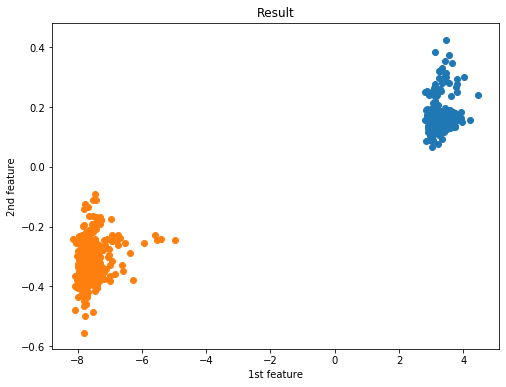

In [47]:
# trainから抽出した特徴量でtestを分離
feature_1 = result_cello.epoch(4)[0](test)
# feature_1_ = result_cello.epoch(4)[2](test)
feature_2 = result_saxphone.epoch(4)[0](test)
# display_([feature_1], datanum=[345, 345])
# display_([feature_2], datanum=[345, 345])
# display_([feature_1, feature_1_], datanum=[345, 345])
# display_([feature_1, feature_1], datanum=[345, 345])
display_([feature_1, feature_2], datanum=[345, 345])

## 分離できた！！


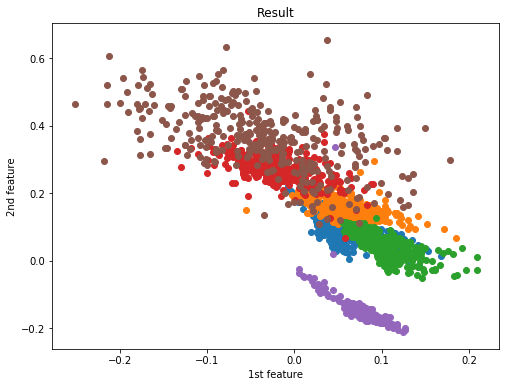

In [236]:
# trainから抽出した特徴量でtrainを分離
feature_1 = result_cello.epoch(6)[0](np.concatenate((train, test, cello, saxphone), axis=0))
feature_2_ = result_saxphone.epoch(6)[2](np.concatenate((train, test, cello, saxphone), axis=0))
# feature_2 = result_saxphone.epoch(4)[1](np.concatenate((train, test, cello, saxphone), axis=0))
display_([feature_1, feature_2_], datanum=[345, 345, 345, 345, 345, 345])

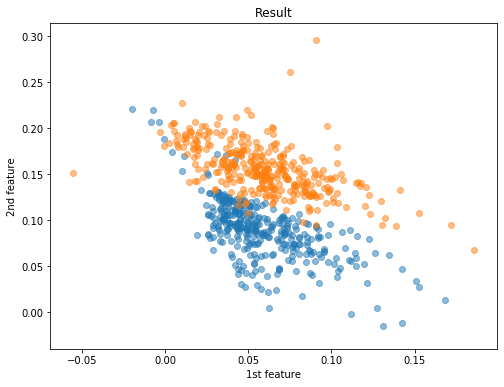

In [280]:
# trainから抽出した特徴量でtrainを分離
feature_1 = result_cello.epoch(6)[0](train)
feature_2_ = result_saxphone.epoch(6)[2](train)
# feature_2 = result_saxphone.epoch(4)[1](np.concatenate((train, test), axis=0))
display_([feature_1,feature_2_], datanum=[345,345])

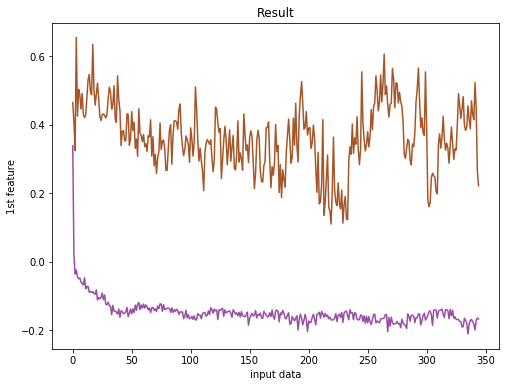

In [272]:
# trainから抽出した特徴量でtrainを分離
feature_1 = result_cello.epoch(6)[0](np.concatenate((cello, saxphone), axis=0))
feature_2_ = result_saxphone.epoch(6)[2](np.concatenate((cello, saxphone), axis=0))
# feature_2 = result_saxphone.epoch(4)[1](np.concatenate((train, test), axis=0))
display_([feature_2_], datanum=[345,345])

#0.18

In [71]:
%%time
from aireference import AIR


air = AIR()

result_test = air(test, ref)

Wall time: 3min 5s


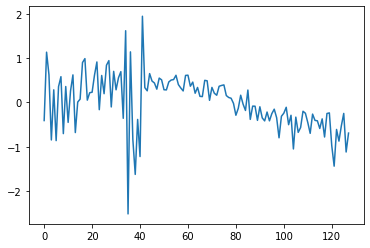

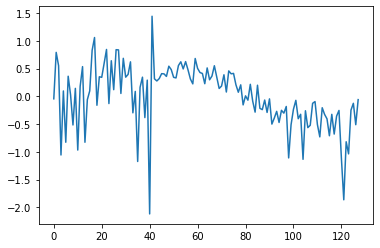

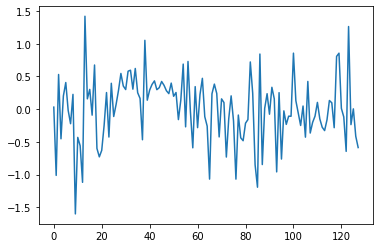

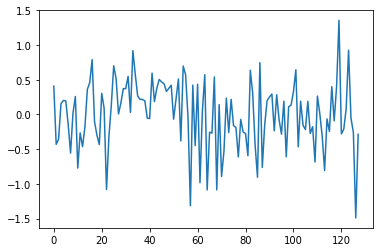

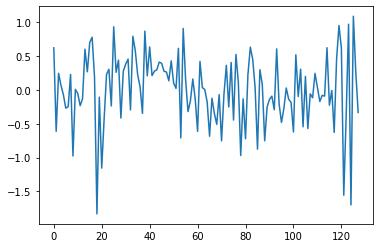

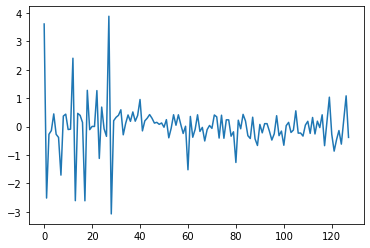

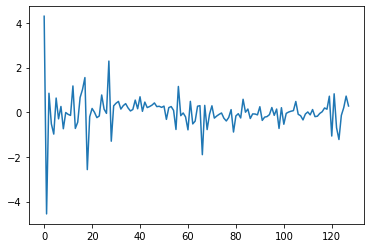

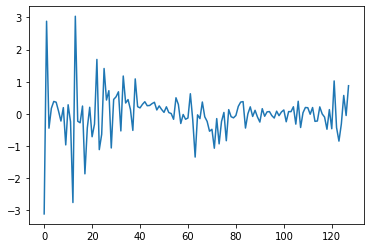

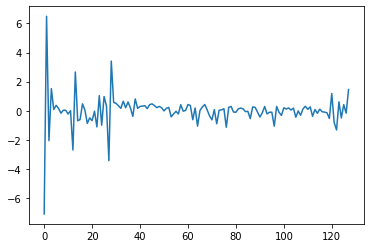

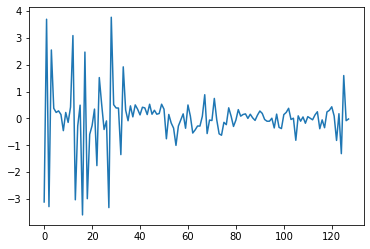

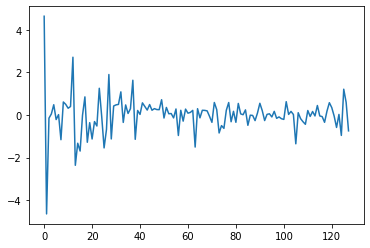

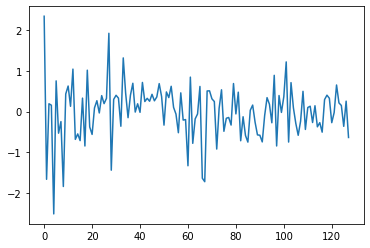

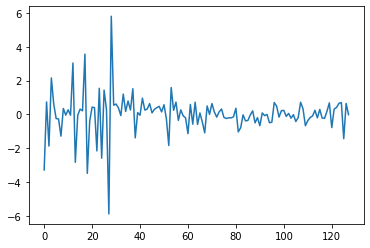

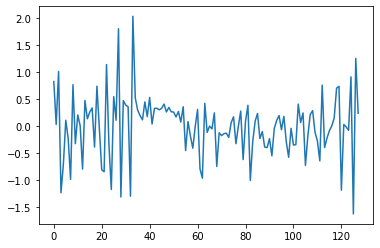

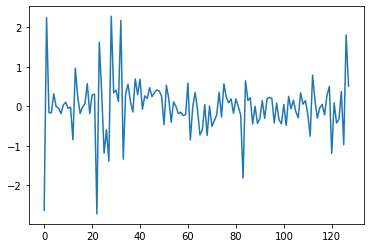

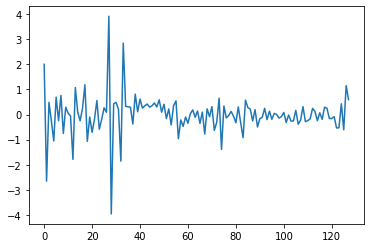

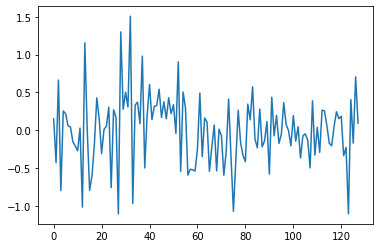

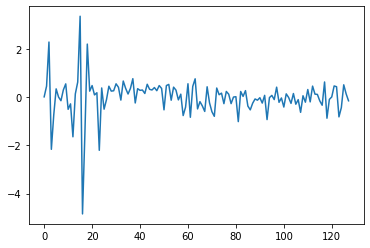

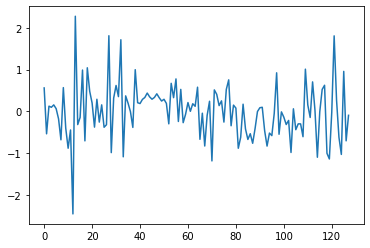

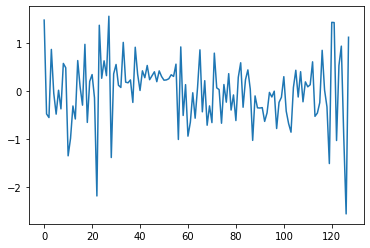

In [72]:
for i in range(20):
    result_test.epoch(1)[i].show()

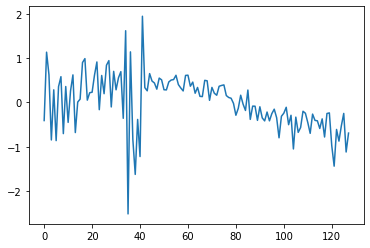

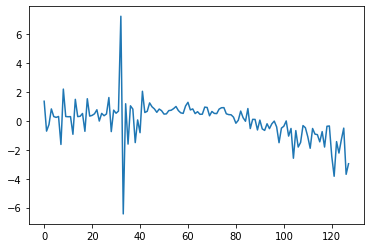

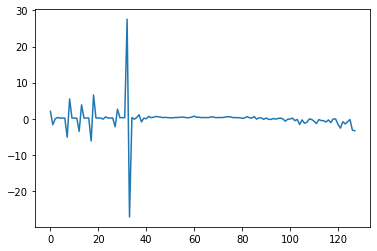

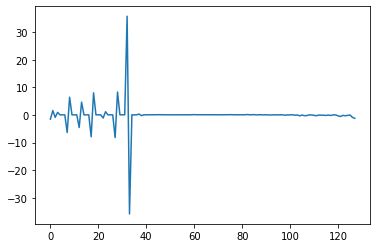

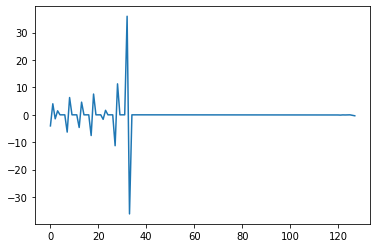

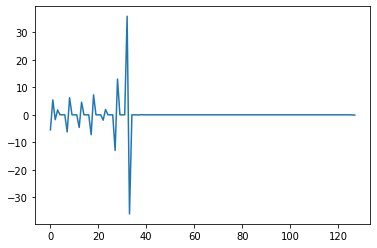

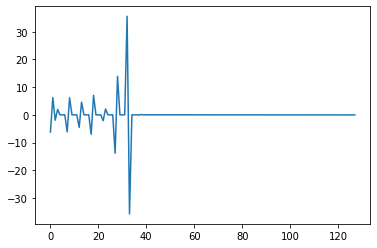

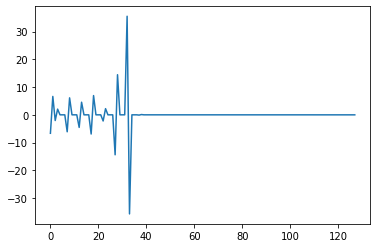

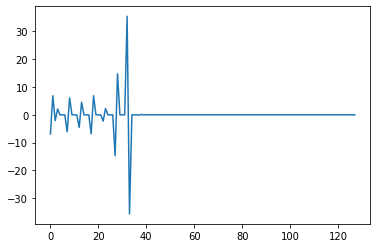

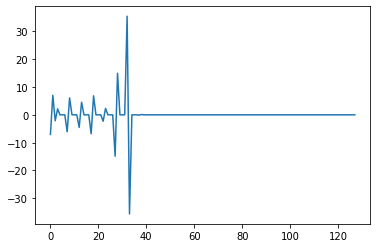

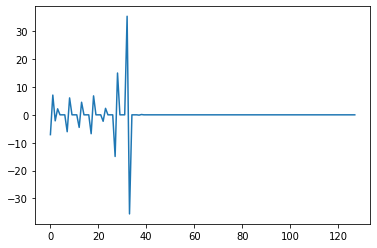

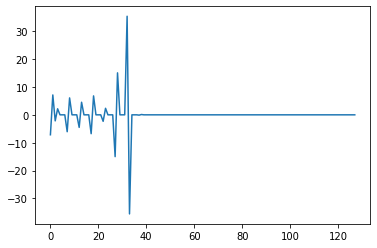

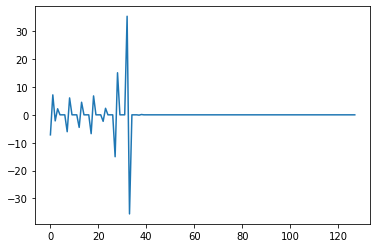

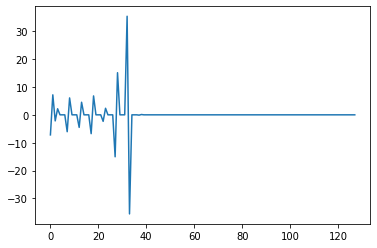

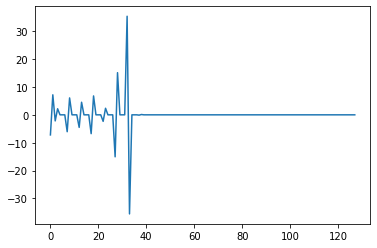

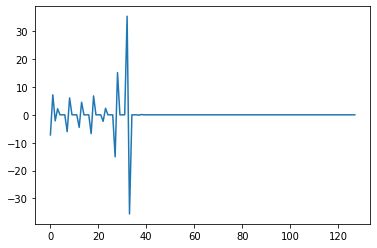

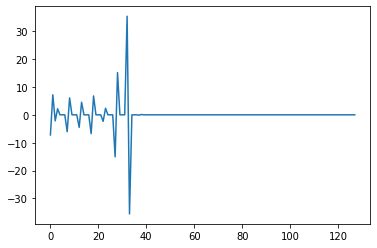

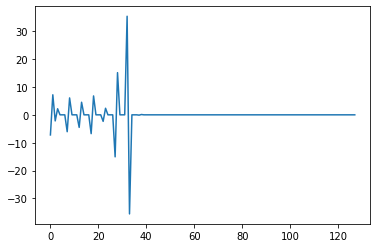

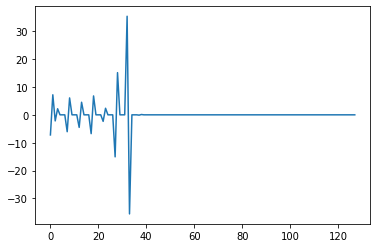

In [73]:
for i in range(1,20):
    result_test.epoch(i)[0].show()

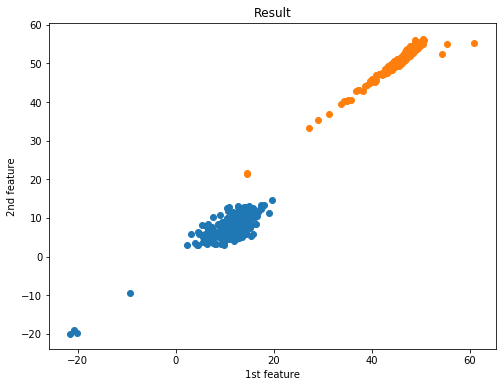

In [78]:
# testから抽出した特徴量でtrainを分離
feature_1 = result.epoch(1)[0](train)
feature_2 = result.epoch(1)[1](train)
display_([feature_1, feature_2], datanum=[345, 345])

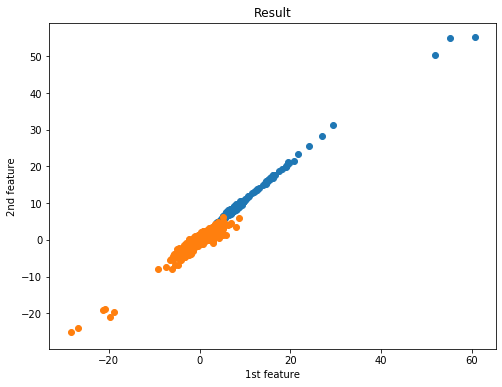

In [79]:
# testから抽出した特徴量でtestを分離
feature_1 = result.epoch(1)[0](test)
feature_2 = result.epoch(1)[1](test)
display_([feature_1, feature_2], datanum=[345, 345])